In [2]:
import imageio.plugins.opencv
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

In [5]:
#load data using Keras Utility

batch_size = 32
img_height = 180
img_width = 180

train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)
val_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

class_names = train_dataset.class_names
# print(class_names)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
#visualize data

# plt.figure(figsize=(10, 10))
# for images, labels in train_dataset.take(1):
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(class_names[labels[i]])
#
# plt.show()


In [6]:
# Prefetching

AUTOTUNE = tf.data.AUTOTUNE
trains_ds = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
vals_ds = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

#standardize data

normalize = layers.Rescaling(1/255)
normalized_ds = trains_ds.map(lambda x, y: (normalize(x), y))
image_batch, label_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.97978985


In [7]:
#basic keras model
num_classes = len(class_names)

model = keras.Sequential([
    layers.Rescaling((1/255), input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

D:\Moin\PycharmProject\MachineLearning\.venv\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
epochs = 5
history = model.fit(
    trains_ds,
    validation_data=vals_ds,
    epochs=epochs,
)

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 31s 312ms/step - accuracy: 0.3962 - loss: 1.4242 - val_accuracy: 0.6158 - val_loss: 1.0015
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 242ms/step - accuracy: 0.6483 - loss: 0.9243 - val_accuracy: 0.6431 - val_loss: 0.8967
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 243ms/step - accuracy: 0.7372 - loss: 0.6875 - val_accuracy: 0.6635 - val_loss: 0.8789
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 236ms/step - accuracy: 0.8178 - loss: 0.4955 - val_accuracy: 0.6471 - val_loss: 0.9203
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 243ms/step - accuracy: 0.9092 - loss: 0.2850 - val_accuracy: 0.6853 - val_loss: 1.0480


Text(0.5, 1.0, 'Training and Validation Accuracy')

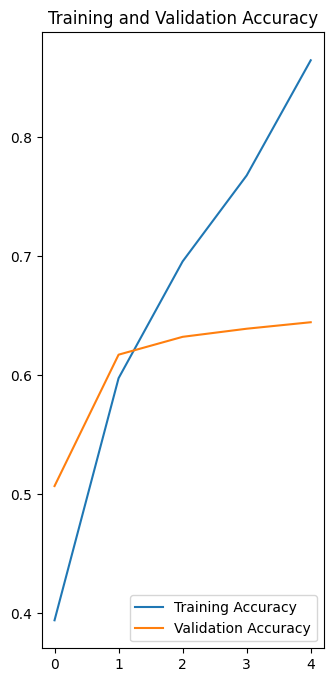

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

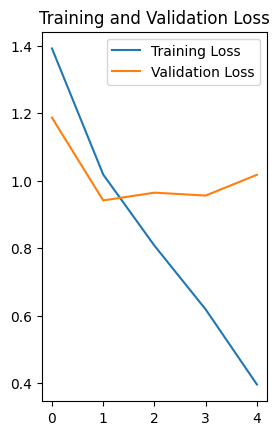

In [12]:
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [17]:
model.save('D:/Moin/PycharmProject/MachineLearning/model.keras')

In [25]:
model = keras.models.load_model('D:/Moin/PycharmProject/MachineLearning/model.keras')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,967,857 (45.65 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,978,572 (30.44 MB)

In [113]:
from PIL import Image

pred_img = Image.open('D:/Moin/PycharmProject/MachineLearning/Images/tl.jpg')
pred_img = pred_img.resize((img_height, img_width))
pred_img = np.array(pred_img)
pred_img = np.expand_dims(pred_img, axis=0)



In [105]:
pred_img.shape

(1, 180, 180, 3)

In [114]:
pred = model.predict(pred_img)
predicted_class = np.argmax(pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [115]:
print(predicted_class)

4


In [116]:
print(class_names[predicted_class])

tulips


In [97]:
pred_img = tf.keras.utils.load_img(
    'D:/Moin/PycharmProject/MachineLearning/Images/daisy_1.jpg', target_size=(img_height, img_width)
)
pred_img_array = tf.keras.utils.img_to_array(pred_img)
pred_img_array = np.expand_dims(pred_img_array, axis=0)
predictions = model.predict(pred_img_array)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


In [98]:
print(class_names[np.argmax(predictions)])

daisy
